# 0. FUNCTIONS

In [1]:
import os
import sys
import math
import random
import pickle
import warnings
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from bisect import bisect_left
from itertools import combinations
from math import sqrt

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import MonthEnd
from matplotlib.patches import Rectangle

from scipy import stats
from scipy.stats import (norm, skew, kurtosis, pearsonr, spearmanr, kendalltau)
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error

import pysal
from numpy.random import Generator, PCG64
from functools import partial


file = "C:/Users/jarra/Desktop/RA ASSISTANT/FINALISED/"

import sys
sys.path.append(file)

import nbimporter
import FUNCTION_LIST as ChatJR # This will import all top-level functions/definitions from the notebook



# 0.1 CHATJR FUNCTIONS

In [2]:
import inspect

# List all functions defined in the imported notebook
functions_list = [name for name, obj in inspect.getmembers(ChatJR) if inspect.isfunction(obj)]
functions_list

['Converters',
 'Correct_Pres',
 'Correct_Temp',
 'Linear_Regression_Equations',
 'Perth_Combination',
 'Reduce_to_MSLP_V2_2',
 'SD_Y_WMO_GL',
 'Storm_Finder_AP_2009',
 'TO_MSLP',
 'UQC_pres_formats',
 'WMO_Guide_Months',
 'c_to_f',
 'calculate_gravity',
 'corr_sig',
 'curve_fit',
 'f_to_c',
 'filter_dataframe_by_months',
 'get_ipython',
 'kendalltau',
 'kurtosis',
 'linear_regression_polyfit',
 'mean_squared_error',
 'pearsonr',
 'qm_transfer',
 'rh_fmt_row_day_mean',
 'rh_fmt_row_month_mean_all',
 'rh_fmt_row_month_mean_via_WMO_Guide',
 'rolling_cross_correlate',
 'running_correlation_with_p',
 'skew',
 'spearmanr',
 'ymd_column']

# 1. DATA DOWNLOAD

## 1.1 PERTH REGIONAL OFFICE

In [3]:
#Pressure transcribed downloaded
PRO_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_PRESSURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Pres_Trans.set_index('Date',inplace = True)
PRO_Pres_Trans.index= pd.to_datetime(PRO_Pres_Trans.index,dayfirst = True,format='mixed')

#Temperature transcribed downloaded
PRO_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\PERTH_REGIONAL_OFFICE_TEMPERATURE_TRANSCRIBED_SUBDAILY_1907-1944.csv")
PRO_Temp_Trans.set_index('Date',inplace = True)
PRO_Temp_Trans =PRO_Temp_Trans[['degF']]
PRO_Temp_Trans.index= pd.to_datetime(PRO_Temp_Trans.index,dayfirst = True,format='mixed')


# 2. DOWNLOAD FOR UQC

In [4]:
#Applying the UQC format onto Perth Regional Office Early

PRO_E_T_UQC = ChatJR.UQC_pres_formats(PRO_Pres_Trans*33.86) 

Downloading_Ag = True
if Downloading_Ag == True:
    #Outline the stations for file saving
    #1. stnumberdecoder name of metadata but including SLP between station number and coutnry
    #CountrySLPstnumber

    #Perth Regional Office Early as code 001
    stnumber = "AustrSLP001"
    PRO_E_T_UQC.to_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\SLP-snowQC\{}.xlsx".format(stnumber), index=False)  # Set index to False if you don't want to include the index in the Excel file



# 3. IDENTIFY AND FIX UQC BREAKPOINTS

BivOutlier	AustrSLP001	1908	5	19	SLP9	SLP15	1010.4501	996.5675	13.88
Transcription error SLP9 the 4 and 8 were switched around

BivOutlier	AustrSLP001	1909	7	16	SLP9	SLP15	1006.5901	994.2312	12.36
Transcription error SLP15 the 6's and 3's were switched around

BivOutlier	AustrSLP001	1909	10	25	SLP9	SLP15	1012.0077	998.87	13.14
No Action

Outlier	AustrSLP001	1909	12	22	SLP9	984.9197
Transcription error SLP9 29 should be 30 29->30

1910-01-21 9 
Transcription error SLP9 28-> 29
Outlier	AustrSLP001	1910	1	21	SLP9	977.4028 - UPDATED PREVIOUSLY
Transcription error SLP9 28 should be 29

BivOutlier	AustrSLP001	1910	5	22	SLP9	SLP15	1001.4434	1034.423	32.98
Transcription error SLP15 30 should be 29 30-> 29

BivOutlier	AustrSLP001	1910	8	24	SLP9	SLP15	1021.4208	984.9874	36.43
Transcription error SLP15 29 should be 30 29->30

BivOutlier	AustrSLP001	1910	8	25	SLP9	SLP15	1021.1499	983.5653	37.58
Transcription error SLP15 29 should be 30 29 -> 30

BivOutlier	AustrSLP001	1911	8	16	SLP9	SLP15	1034.8293	1022.7074	12.12
Transcription error SLP9 562 should be 256 30.562 -> 30.256

BivOutlier	AustrSLP001	1911	9	27	SLP9	SLP15	1019.5923	1030.6984	11.11
Transcription error SLP15 44 should be 044 30.44 -> 30.044

BivOutlier	AustrSLP001	1912	5	4	SLP21	SLP15	1001.5111	1010.8564	9.35
Transcription error SLP15 8 and 5 were requred to be flipped 29.854 -> 29.584

BivOutlier	AustrSLP001	1912	5	22	SLP9	SLP15	1049.186	1016.0032	33.18
1912-05-22 9 30 -> 29

Outlier	AustrSLP001	1913	3	29	SLP9	1046.4772
Rub Out error, odd why, but this is 30 to 29 1913-03-29 9 30 -> 29 CLEAR TO SEE RUB OUT OF 29 AND INPLACE 30, BUT THATS WRONG

Outlier	AustrSLP001	1913	3	30	SLP9	1049.186
Rub Out error, odd why, but this is 30 to 29 1913-03-30 9 30-> 29 HE RUSHED IT CAN SEE 29 DAYS BEFORE 30 SAME AS 9PM TO

Outlier	AustrSLP001	1913	4	13	SLP21	983.9716
Unrealistic change 29 ->30 at 21 clear wrong

Outlier	AustrSLP001	1913	4	14	SLP15	984.3779
Unrealistic change 29 ->30 at 15 clear wrong

Outlier	AustrSLP001	1913	4	14	SLP21	985.326
Unrealistic change 29 ->30 at 15 clear wrong

Outlier	AustrSLP001	1913	4	20	SLP15	983.4298
Unrealistic change 29 ->30 at 15 clear wrong

Outlier	AustrSLP001	1913	4	21	SLP15	984.7842
Unrealistic change 29 ->30 at 15 clear wrong

Outlier	AustrSLP001	1913	4	22	SLP21	1048.7119 - UPDATED PREVIOUSLY
Unrealsitc changes, 30 to 29

Outlier	AustrSLP001	1913	4	23	SLP9	1047.8993 - UPDATED PREVIOUSLY
Unrealsitc changes, 29 to 30

BivOutlier	AustrSLP001	1913	6	7-8	SLP9	SLP15	1009.5698	1018.6442	9.07
Wrong order
Correct
7-9am 29.816
29.744
29.856
8-9am 30.112
30.084
30.112
Wrong order
29.816
30.084
30.112
30.112
29.744
29.856

BivOutlier	AustrSLP001	1913	7	9	SLP21	SLP15	986.9513	1020.3372	33.39
Transcription error SLP21 29 should be 30 29 -> 30

BivOutlier	AustrSLP001	1913	7	10	SLP21	SLP15	984.9874	1019.8632	34.88
Transcription error SLP21 29 should be 30 29 -> 30


BivOutlier	AustrSLP001	1918	10	15-28	SLP21	SLP15	1007.335	1014.107	6.77
This enture period from the 15th to the 28th were transcribed wrong by 1 day for 9pm
TIMESERIES CHANGE
29.812	29.824
29.776	
29.708	
29.824	29.754
29.9	
29.914	
29.754	29.982
30.028	
29.93	
29.982	29.932
29.908	
29.906	
29.932	29.962
29.926	
29.836	
29.962	29.816
29.688	
29.68	
29.816	29.75
29.896	
29.95	
29.75	30.008
30	
29.936	
30.008	29.914
29.908	
29.918	
29.914	29.95
29.964	
29.95	
29.95	29.968
29.998	
29.932	
29.968	29.898
29.756	
29.638	
29.898	29.584
29.54	
29.582	
29.584	29.684

BivOutlier	AustrSLP001	1919	6	8	SLP9	SLP15	997.7188	1005.5743	7.86
No issue

BivOutlier	AustrSLP001	1919	7	14	SLP9	SLP15	1048.8474	1012.9558	35.89
Observer error, 30 swaped to 29, not realist 1919-07-14 9 30->29

BivOutlier	AustrSLP001	1921	2	18	SLP21	SLP15	994.9422	1001.5788	6.64
Transcirption error, 3 should be 5 29.384 -> 29.584 - CAN SEE IT IN THE ADJUSTED, 15PM WAS 599, AND THEN 21 WAS 606, THIS WOULD NOT MAKE SENSE AT 384.

BivOutlier	AustrSLP001	1921	9	16	SLP21	SLP15	1007.1996	995.9919	11.21
Looks fine no issue

BivOutlier	AustrSLP001	1922	6	7	SLP15	SLP9	1007.0641	999.0054	8.06
Looks fine no issue

BivOutlier	AustrSLP001	1923	3	25	SLP15	SLP9	998.5314	1008.0122	9.48
Looks fine no issue

Outlier	AustrSLP001	1924	4	7	SLP9	988.1702
TRANSCRIPTION error, 29 swaped to 30, not realist

Outlier	AustrSLP001	1924	4	8	SLP9	989.7278
TRANSCRIPTION error, 29 swaped to 30, not realist

Outlier	AustrSLP001	1924	4	9	SLP9	985.0551
TRANSCRIPTION error, 29 swaped to 30, not realist

BivOutlier	AustrSLP001	1924	6	11	SLP15	SLP9	1002.3237	1011.3982	9.07
Looks fine no issue

BivOutlier	AustrSLP001	1924	6	18	SLP21	SLP15	985.1906	1017.3237	32.13
Transcription issue 29 to 30  AT 9PM


Outlier	AustrSLP001	1925	11	11	SLP15	1041.3982
Transcription issue 30 to 29
1925-11-11 15 30->29


Outlier	AustrSLP001	1926	2	3	SLP21	978.4863
Transcription issue Chnaged 9 to 7 AT 9PM AS IT LOOKS NATURAL THAT WAY AND ALSO 28 TO 29 ALSO THE NYMBER LOOKS SIMILAR TO THE 7 ON THE FIRST 28.898 TO 29.878

BivOutlier	AustrSLP001	1926	2	24	SLP9	SLP15	1005.3034	1014.6149	9.31
Transcription issue swapped 6 and 9 for 9am 29.690 -> 29.960


Outlier	AustrSLP001	1927	3	17	SLP9	1049.3214
1927-03-17 9 30->29 Written down as 30 but its wrong for sure
Transcription issue swapped 30 to 29 for this date 

Outlier	AustrSLP001	1927	3	19	SLP9	1043.0912
1927-03-19 9 30->29
Transcription issue swapped 30 to 29 for this date 

BivOutlier	AustrSLP001	1927	6	3	SLP21	SLP15	999.0054	1004.6262	5.62
No issue 


BivOutlier	AustrSLP001	1927	9	2	SLP21	SLP15	1010.3147	1001.8497	8.47
No Issue

Outlier	AustrSLP001	1928	1	18	SLP9	980.0438
1928-01-18 9 28-> 29

BivOutlier	AustrSLP001	1928	7	16	SLP21	SLP15	987.2222	995.7549	8.53
No Issue

BivOutlier	AustrSLP001	1930	5	8	SLP9	SLP15	997.3802	1004.6262	7.25
No Issue

BivOutlier	AustrSLP001	1930	7	3-4	SLP21	SLP15	999.4795	1009.2989	9.82
DatesOF 3RD AND 4TH ARE flipped the rest of the dates
OLD      NEW
29.872	29.872
29.808	29.808
29.518	29.518
29.756	29.716
29.746	29.576
29.774	29.588
29.716	29.756
29.576	29.746
29.588	29.774
29.604	29.604

BivOutlier	AustrSLP001	1930	8	20	SLP15	SLP9	1022.6397	1017.019	5.62
30.036 -> 30.306 transcription error in 9am

BivOutlier	AustrSLP001	1931	4	12	SLP21	SLP15	1013.4975	1004.8294	8.67
No issue


BivOutlier	AustrSLP001	1931	5	8	SLP21	SLP15	993.9942	1003.8813	9.89
It is a 4 because of the adjusmtet which is 0.082 if you use for which is the same for the day previous
29.648 -> 29.448

1931-05-26 9 NATURAL

BivOutlier	AustrSLP001	1932	5	28	SLP15	SLP9	997.0416	1005.9806	8.94
Natural


BivOutlier	AustrSLP001	1932	6	10	SLP9	SLP15	1001.7142	1014.9196	13.21
It is a 8 because of the adjusmtet which is 0.96 if you use for which is the same for the day previous
it is similar
29.584 -> 29.884

BivOutlier	AustrSLP001	1932	8	1	SLP15	SLP9	995.6872	1004.6262	8.94
Natural

BivOutlier	AustrSLP001	1933	5	22	SLP9	SLP15	1000.9016	1035.8451	34.94
Transcription issue swapped 30 to 29 at 3pm


BivOutlier	AustrSLP001	1933	7	25	SLP9	SLP15	1000.2244	1007.0641	6.84 - done previously
No issue

BivOutlier	AustrSLP001	1934	5	7	SLP21	SLP15	994.1296	1001.3756	7.25 done previously
No issue

Outlier	AustrSLP001	1935	1	13	SLP15	969.3441 
28 -> 29

BivOutlier	AustrSLP001	1935	5	4	SLP21	SLP15	1026.2966	1016.6126	9.68
Trasncription Error added 0 after decimal 30.31 -> 30.031

BivOutlier	AustrSLP001	1935	7	8	SLP21	SLP15	995.8903	1001.7142	5.82
No isse this date by transcrption error on the 6th 7 was changed to 01 30.14 to 30.014


BivOutlier	AustrSLP001	1936	5	21	SLP21	SLP15	1009.1634	999.344	9.82
No issue

BivOutlier	AustrSLP001	1937	5	18	SLP9	SLP15	995.8903	1003.2041	7.31
No issue

BivOutlier	AustrSLP001	1937	6	21	SLP21	SLP15	1010.8564	1001.3079	9.55
No issue

BivOutlier	AustrSLP001	1938	7	4	SLP9	SLP15	1043.8361	1007.0641	36.77
Trasncription Error 30 to 29 1938-07-04 9 30->29

BivOutlier	AustrSLP001	1938	10	6	SLP21	SLP15	1013.7684	1005.2357	8.53
No issue 

BivOutlier	AustrSLP001	1940	5	30	SLP9	SLP15	991.9626	1022.3688	30.41
Trasncription Error 29 to 30 9am


BivOutlier	AustrSLP001	1941	7	9	SLP21	SLP15	998.9377	1014.4456	15.51
Trasncription Error 9 to 6 3pm 29.96 to 29.66

BivOutlier	AustrSLP001	1942	1	28	SLP21	SLP15	1015.1905	1005.7097	9.48
Trasncription Error 9 to 7 in 9pm  29.982 to 29.782

BivOutlier	AustrSLP001	1942	9	17	SLP9	SLP15	1013.2266	1000.4276	12.8
Trasncription Error 9 to 6 i 9am, 29 29.924 to 29.624

BivOutlier	AustrSLP001	1942	10	25	SLP21	SLP15	1002.9671	1013.4298	10.46
Trasncription Error 9 to 6 29.93 -> 29.63 in 3pm

BivOutlier	AustrSLP001	1943	6	15	SLP21	SLP15	999.2763	1005.0325	5.76
No issue

BivOutlier	AustrSLP001	1943	8	24	SLP21	SLP15	1027.651	1019.5923	8.06
No issue

BivOutlier	AustrSLP001	1943	9	8	SLP21	SLP15	1015.5968	1001.6465	13.95
Trasncription Error 8 and 5 swapped in 3pm  29.582 ->29.852



# TEMPERATURE

In [5]:
PRO_Temp_Trans_C = ChatJR.f_to_c(PRO_Temp_Trans)
data = PRO_Temp_Trans_C

data['degC'] = data['degF']
data = data[['degC']]
data = data.sort_index()
data

,degC
Date,
1907-01-01 09:00:00,22.2
1907-01-01 15:00:00,22.8
1907-01-01 21:00:00,NaN
1907-01-02 09:00:00,21.8
1907-01-02 15:00:00,23.9
...,...
1944-03-29 15:00:00,22.2
1944-03-30 09:00:00,22.4
1944-03-30 15:00:00,22.6


In [6]:
# Create a complete datetime index with 9am, 3pm, and 9pm from the min to max date
full_dates = pd.date_range(
    start=data.index.min().normalize(),
    end=data.index.max().normalize(),
    freq='D'
)

In [7]:
# Define the times to include for each date (9am, 3pm, 9pm)
times = [pd.Timedelta(hours=9), pd.Timedelta(hours=15), pd.Timedelta(hours=21)]

# Create a list of all possible datetimes (every date with 9am, 3pm, and 9pm)
full_datetime_index = pd.to_datetime([d + t for d in full_dates for t in times])

# Reindex the original data to this full index (fills missing times with NaN)
data = data.reindex(full_datetime_index)

In [8]:
app_data = []
for value in sorted(data.index.hour.unique().values):
    subset = data[data.index.hour == value]
    subset.index = subset.index.normalize()
    subset.columns = [str(value)]
    
    app_data.append(subset)

test = pd.concat(app_data,axis=1)   

test = ChatJR.ymd_column(test)
test = test.round(1)
test.fillna(-99.9,inplace=True)
test

,year,month,day,9,15,21
0,1907,1,1,22.2,22.8,-99.9
1,1907,1,2,21.8,23.9,-99.9
2,1907,1,3,22.7,22.8,-99.9
3,1907,1,4,20.4,21.4,-99.9
4,1907,1,5,19.4,22.4,-99.9
...,...,...,...,...,...,...
13600,1944,3,27,21.9,22.2,-99.9
13601,1944,3,28,21.6,21.4,-99.9
13602,1944,3,29,21.6,22.2,-99.9
13603,1944,3,30,22.4,22.6,-99.9


In [9]:
# Define the output file path
output_path = r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\UQC\AustrTT001.dat"

# Open the file in write mode and save the formatted data
with open(output_path, 'w') as file:
    # Write the header information (specific to your format)
    file.write("perth_reg_1907-43\n")  # Modify if needed
    file.write("01 01 1907 31 12 1943\n")  # Modify date range if needed
    file.write("3\n")  # Assuming this is the number of columns

    # Prepare the DataFrame and reset the index (without index)
    formatted_data = test.reset_index(drop=True)  # Ensure index is not written

    # Manually set column labels to represent the hours: 9, 15, and 21
    formatted_data.columns = ['year', 'month', 'day', '9', '15', '21']

    # Save the DataFrame to file, without index and with header row
    formatted_data.to_csv(file, sep='\t', index=False, header=True, float_format="%.1f")

# Confirm the file is saved
print("File saved to:", output_path)


File saved to: C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\UQC\AustrTT001.dat


pregoTT001.dat 1909  1 28 15  6     7.9
TE 60.3 - 69.3 at 9am

pregoTT001.dat 1912  2 29 15  6    -7.9
NI

pregoTT001.dat 1912  7  2 21  6     6.6
NI

pregoTT001.dat 1912  7  3 15  6    -6.8
NI

pregoTT001.dat 1912  7  3 21 12    -6.8
NI

pregoTT001.dat 1913  1 11 21  6    -6.0
NI

pregoTT001.dat 1913  6 10 21  6     6.6
NI - but the period where 7th and 8th are swapped in press are done here to
Old New
63	63
68	68
66.2	66.2
61.8	62.7
65.1	65.7
62.2	58.5
62.7	61.8
65.7	65.1
58.5	62.2

pregoTT001.dat 1914  3  6 21 12     6.2
NI

pregoTT001.dat 1914  3 22 21  6     6.3
NI

pregoTT001.dat 1914 10  5 21  6    -7.8
NI

pregoTT001.dat 1914 10  6  9 12     6.1
NI

pregoTT001.dat 1915  1 21 15  6     8.3
NI

pregoTT001.dat 1915 11 29 21 12    -7.4
NI

pregoTT001.dat 1916  2 26  9 12    -7.5
NI

#1916-12-15 21:00:00 F66.9 not 6.9 AustrTT001.dat 1916 12 16  9 12    35.4
TE

pregoTT001.dat 1918  1 12 21  6    -7.2
NI

pregoTT001.dat 1918  2 24 21 12    -6.9
NI

#1918-06-20 15:00:00 F66.6 not 6.66 - AustrTT001.dat 1918  6 20 15 12     1.7   -30.9     0.7
TE


pregoTT001.dat 1919  7  4 15  6     6.2
NI

pregoTT001.dat 1919  7  9 21  6    -6.2
NI

pregoTT001.dat 1920  5 31  9 12     6.5
NI

pregoTT001.dat 1920  8  9 21 12    -6.5
NI

pregoTT001.dat 1921  7  1 15  6    -6.2
NI

pregoTT001.dat 1922  2 25  9 12    -6.4
NI

pregoTT001.dat 1924  6 14  9 12     6.2
NI

#1924-08-25 09:00:00 F52.2 not 0.2
TE

#1924-08-25 09:00:00 F52.2 not 0.2
TE

1926-10-27 9 T (672 -> 67.2) ######### DO NOT INCLUDE IN COUNT
#1926-10-27 09:00:00 F67.2 not 672
TE

pregoTT001.dat 1927  1 19 15  6    -6.8
NI

pregoTT001.dat 1931  1  5 21 12    -6.3
NI

pregoTT001.dat 1934  4  8  9 12    -6.5
NI

pregoTT001.dat 1934 12 11 15  6    -6.3
NI

pregoTT001.dat 1934 12 29 21 12    -6.1
NI

pregoTT001.dat 1935  1 30 21 12     6.5
NI 

pregoTT001.dat 1936  6 15  9 12     7.1
NI

pregoTT001.dat 1937  2 15 21 12    -7.9
NI

pregoTT001.dat 1937  6  4 15  6     6.4
NI

pregoTT001.dat 1938  9 22 15  6     6.7
NI

pregoTT001.dat 1938 11 17 21  6    -8.8  17 9pm 59 to 69
TE

pregoTT001.dat 1939 12 30 21  6     6.2
NI

pregoTT001.dat 1940  2 27  9 12    -6.2
NI

pregoTT001.dat 1940  4 25 15  6     6.9
NI

pregoTT001.dat 1940  8 19 15  6     6.0
NI

pregoTT001.dat 1940  8 21 15  6     6.6
NI

pregoTT001.dat 1940  9 12 21 12    -6.1 9am 65.5 to 56.5
TE

pregoTT001.dat 1941  3  9 15  6     8.0
NI

pregoTT001.dat 1941  8 24 15  6     6.6
NI

pregoTT001.dat 1941 10 31  9 12     7.0
NI

# 4. ADD SWAN RIVER INTO HERE

In [10]:
'''Pressure Transcribed'''
SWR_Pres_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_PRESSURE_TRANSCRIBED_SUBDAILY_1830-1875.csv",
                                index_col=0, parse_dates=True, header=None,names=['Date','Pressure (inHg)'])
SWR_Pres_Trans.index= pd.to_datetime(SWR_Pres_Trans.index,format='mixed',dayfirst = True)
SWR_Pres_Trans = SWR_Pres_Trans.dropna()    
'''Temperature  Transcribed'''
SWR_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_TEMPERATURE_TRANSCRIBED_SUBDAILY_1830-1875.csv")
SWR_Temp_Trans['Date']= pd.to_datetime(SWR_Temp_Trans['date'],dayfirst = True,format='mixed')
SWR_Temp_Trans = SWR_Temp_Trans[['Date','temp']]
SWR_Temp_Trans.set_index('Date',inplace = True)
#SWR_Temp_Trans = SWR_Temp_Trans.dropna()    

In [11]:
#Applying the UQC format onto Swan River record

PRO_E_T_UQC = ChatJR.UQC_pres_formats(SWR_Pres_Trans*33.86) 

Downloading_Ag = True
if Downloading_Ag == True:
    #Outline the stations for file saving
    #1. stnumberdecoder name of metadata but including SLP between station number and coutnry
    #CountrySLPstnumber

    #Swan River as code 002
    stnumber = "AustrSLP002"
    PRO_E_T_UQC.to_excel(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\SLP-snowQC\{}.xlsx".format(stnumber), index=False)  # Set index to False if you don't want to include the index in the Excel file



Outlier	AustrSLP001	1830	5	22	SLP15	983.633
It says 29.05, btu I think it should be 30.05 - over 7SDs away from the mean, so updated to 30.05

BivOutlier	AustrSLP001	1832	7	4	SLP16	SLP10	1012.414	1024.265	11.85
FINE NO UPDATE

TRANSCRIPTION ERROR 1832-12-05
29.98 TO 29.90 10AM

BivOutlier	AustrSLP001	1832	12	8	SLP10	SLP16	1017.493	1032.73	15.24
TE 30.5 -> 30.05

BivOutlier	AustrSLP001	1841	4	3	SLP10	SLP16	1032.73	1023.9264	8.8
TE 16PM 30.24 -> 30.42

Outlier	AustrSLP001	1841	10	31	SLP16	988.712
TE 29.2 -> 29.92 16PM

BivOutlier	AustrSLP001	1843	4	11	SLP16	SLP10	1009.028	1016.4772	7.45
FINE NO UPDATE

BivOutlier	AustrSLP001	1845	5	16	SLP10	SLP16	1014.4456	1002.256	12.19
TE 29.6 -> 29.96  4PM

1846-05-04 16 30.53 -> 30.54

BivOutlier	AustrSLP001	1846	5	25	SLP16	SLP10	1001.2402	1008.0122	6.77
FINE NO UPDATE but a storm

BivOutlier	AustrSLP001	1846	7	19	SLP16	SLP10	1006.9964	1014.7842	7.79
TE 29.97 -> 29.79 AT 10AM

BivOutlier	AustrSLP001	1846	9	29	SLP16	SLP10	1035.1002	1028.3282	6.77
TE 30.57 -> 30.37

1848/08/18
I think it should be 30.9, as I have not seen a 30.9 naturally for Perth and the pressure is almost 1046hPa, with this being said, and comparing 
to the values around it, it looks like an outlier and really it should be 20.9. The pressure difference does not match the remarks descpriton where 
its light winds and light showers with calmer conditions. This needs to be checked as this could be an outlier with rain that is not a real storm
30.9 -> 29.9

Outlier	AustrSLP001	1851	8	3	SLP17	1000.563
Real FINE NO UPDATE -- HOWEVER 7/30 AND 7/31 UPDATED BY ADDING 0 SO INSTEAD OF 30.8 ITS 30.08 - DONE BEFORE ME

BivOutlier	AustrSLP001	1854	3	3	SLP10	SLP16	1036.116	1025.958	10.16
For this, I think it should be 30.16, and the transcriber got lazy, unfortuently i dont want to messs with this
30.6 -> 30.16 10am
30.3 -> 30.13 4pm


BivOutlier	AustrSLP001	1854	3	16	SLP10	SLP16	1019.186	1036.116	16.93
Real Fine NO UPDATE
For this, I think it should be 30.16, and the transcriber got lazy, unfortuently i dont want to messs with this, this is if you look at the pressure 
variation over the week
30.6 -> 30.16 4pm

BivOutlier	AustrSLP001	1856	4	10	SLP10	SLP16	1010.0438	1044.2424	34.2
TE 30.84 -> 29.84 4PM

BivOutlier	AustrSLP001	1856	8	16	SLP14	SLP10	1020.879	1016.4772	4.4
Fine No Updated

BivOutlier	AustrSLP001	1858	7	12	SLP10	SLP16	984.9874	1016.4772	31.49
UPDATED AS STORM IDENTIFIED IN THIS PERIOD BUT IT SEEMS THAT IT SHOULD BE 30.09 because (30.38, 29.09, 30.02, 30, 29.97), in the continuous days, this is not correct, it has been transcribed wrong
29.09-> 30.09

1858-08-28
TE 30.035 -> 30.35

BivOutlier	AustrSLP001	1859	4	4	SLP10	SLP16	1034.7616	1023.5878	11.17
TE 30.56 -> 30.36 10AM, AND THIS IS WHEN YOU LOOK AT THE VALUE MEANT TO BE 5, IT LOOKS THE SAME AS THE 3'S ON THE 5TH AND 28/29TH OF THIS PAGE, AND 5S
HAVE A LONG TAIL

BivOutlier	AustrSLP001	1862	5	27	SLP16	SLP10	1009.3666	1017.493	8.13
TE 29.81 -> 29.91 4PM

Outlier	AustrSLP001	1862	11	28	SLP16	983.633
This indicates a clear outlier, we are seeing a drop in inHg from 30.19 at 10am to 29.05 at 4pm and then 30.02 10am the next day. This is up for review
But if the UQC has identified this as a outlier, and knowing this entire page is 30s then it is likely to be changed. However, it does say heavy 
squalls and rain that passed over this period as well. 3pm wind did shift on this day.
28.85 tried this first this is over 7SDs change so it is 30.05   
29.05 -> 30.05 4pm


    
BivOutlier	AustrSLP001	1863	1	9	SLP10	SLP16	1029.344	1020.5404	8.8
No Issue found

BivOutlier	AustrSLP001	1865	7	21	SLP10	SLP16	1029.0054	1019.8632	9.14
No Issue found

BivOutlier	AustrSLP001	1865	9	1	SLP16	SLP10	1018.1702	1007.335	10.84
No Issue found

BivOutlier	AustrSLP001	1867	6	26	SLP16	SLP10	1032.3914	1025.6194	6.77
TE 10am 30.29 -> 30.49

TE 27th 10am 30.28 -> 30.48


BivOutlier	AustrSLP001	1867	7	5	SLP10	SLP16	1034.7616	1025.6194	9.14
TE 4pm 30.29 -> 30.49

BivOutlier	AustrSLP001	1868	6	8	SLP14	SLP10	996.8384	997.177	0.34
No issue found

Outlier	AustrSLP001	1871	10	31	SLP13	1047.2898
TE and time error 30.93 -> 29.93 and 1pm to 4pm

BivOutlier	AustrSLP001	1873	12	26	SLP16	SLP10	1017.8316	1025.958	8.13
No Issue found

BivOutlier	AustrSLP001	1874	6	16	SLP16	SLP10	1002.9332	1010.721	7.79
No ISSUE FOUND

BivOutlier	AustrSLP001	1875	7	15	SLP10	SLP16	1031.3756	1023.2492	8.13
No issue found






# 5. Checking Probabilities
This is a sanity check to figure out the outliers

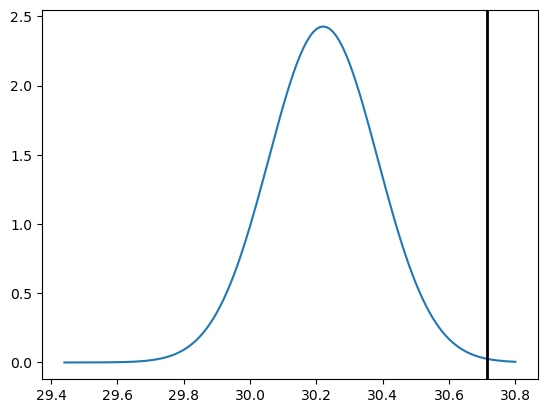

In [12]:
x = np.random.normal(50, 3, 1000)
source = {"Genotype": ["CV1"]*1000, "AGW": x}
df=SWR_Pres_Trans.copy()#['Pressure (inHg)']


df.sort_values(by=['Pressure (inHg)'], inplace=True)
df_mean = np.mean(df["Pressure (inHg)"])
df_std = np.std(df["Pressure (inHg)"])
pdf = stats.norm.pdf(df["Pressure (inHg)"], df_mean, df_std)

STD4 = df_mean + (3*df_std)

plt.plot(df["Pressure (inHg)"], pdf)
plt.axvline(x=STD4, color='black', linestyle='-', linewidth=2)




In [13]:
df[df["Pressure (inHg)"] >= STD4]

,Pressure (inHg)
Date,
1839-08-04 09:00:00,30.72
1849-08-29 10:00:00,30.72
1842-06-30 10:00:00,30.72
1861-07-29 16:00:00,30.72
1839-08-02 09:00:00,30.72
1842-06-30 10:00:00,30.72
1849-08-29 10:00:00,30.72
1861-07-27 10:00:00,30.73
1840-06-21 09:00:00,30.73


In [14]:
df = SWR_Pres_Trans.copy()


# Calculate differences
df['Pressure_Diff'] = df['Pressure (inHg)'].diff()
df['Time_Diff_Hours'] = df.index.diff().total_seconds() / 3600

# Calculate pressure change per hour
df['Pressure_Change_per_Hour'] = df['Pressure_Diff'] / df['Time_Diff_Hours']

#['Pressure (inHg)']

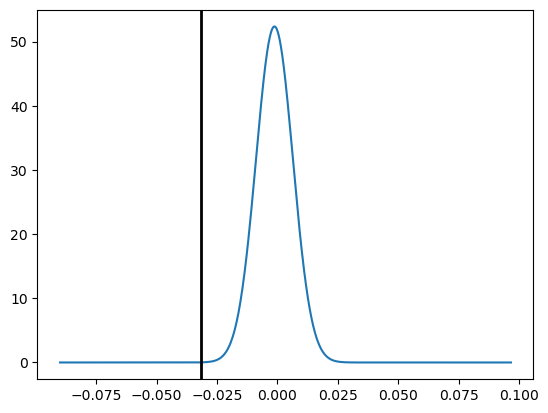

In [15]:
x = np.random.normal(50, 3, 1000)
source = {"Genotype": ["CV1"]*1000, "AGW": x}
df=df.copy()


df.sort_values(by=['Pressure_Change_per_Hour'], inplace=True)
df_mean = np.mean(df["Pressure_Change_per_Hour"])
df_std = np.std(df["Pressure_Change_per_Hour"])
pdf = stats.norm.pdf(df["Pressure_Change_per_Hour"], df_mean, df_std)

STD4 = df_mean - (4*df_std)

plt.plot(df["Pressure_Change_per_Hour"], pdf)
plt.axvline(x=STD4, color='black', linestyle='-', linewidth=2)


In [16]:
df[df['Pressure_Change_per_Hour']<=(df_mean - (7*df_std))]

,Pressure (inHg),Pressure_Diff,Time_Diff_Hours,Pressure_Change_per_Hour
Date,,,,
1854-07-27 12:00:00,30.18,-0.18,2.0,-0.090000
1864-09-10 13:00:00,29.72,-0.16,2.0,-0.080000
1851-04-24 12:00:00,29.95,-0.07,1.0,-0.070000
1846-05-25 11:00:00,29.70,-0.07,1.0,-0.070000
1872-10-05 13:00:00,30.02,-0.20,3.0,-0.066667
1830-07-01 15:00:00,29.60,-0.40,6.0,-0.066667
1847-07-18 13:00:00,29.91,-0.19,3.0,-0.063333
1832-07-04 16:00:00,29.90,-0.35,6.0,-0.058333


In [17]:
df[df['Pressure_Change_per_Hour']>=(df_mean + (7*df_std))]

,Pressure (inHg),Pressure_Diff,Time_Diff_Hours,Pressure_Change_per_Hour
Date,,,,
1865-09-01 16:00:00,30.07,0.32,6.0,0.053333
1831-06-22 15:00:00,29.97,0.35,6.0,0.058333
1847-07-18 16:00:00,30.09,0.18,3.0,0.060000
1833-07-27 15:00:00,30.34,0.30,5.0,0.060000
1846-11-28 18:00:00,30.28,0.14,2.0,0.070000
1871-08-16 13:00:00,30.40,0.25,3.0,0.083333
1873-09-06 13:00:00,30.03,0.29,3.0,0.096667


In [18]:
df.loc['1862-11-28']

,Pressure (inHg),Pressure_Diff,Time_Diff_Hours,Pressure_Change_per_Hour
Date,,,,
1862-11-28 16:00:00,30.05,-0.14,6.0,-0.023333
1862-11-28 10:00:00,30.19,0.01,18.0,0.000556


In [19]:
df.loc['1858-08-28']

,Pressure (inHg),Pressure_Diff,Time_Diff_Hours,Pressure_Change_per_Hour
Date,,,,
1858-08-28 13:00:00,30.35,-0.03,3.0,-0.010000
1858-08-28 10:00:00,30.38,0.33,18.0,0.018333


In [20]:
df.loc['1858-08-30']

,Pressure (inHg),Pressure_Diff,Time_Diff_Hours,Pressure_Change_per_Hour
Date,,,,
1858-08-30 16:00:00,30.27,-0.10,6.0,-0.016667
1858-08-30 10:00:00,30.37,0.02,45.0,0.000444


# 6. QUICK CHECK OF TEMPERATURE SWR

In [22]:
SWR_Temp_Trans_C = ChatJR.c_to_f(SWR_Temp_Trans)


In [23]:
'''Temperature transcribed for swan river'''
SWR_Temp_Trans = pd.read_csv(r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\DATASETS\SWAN_RIVER_TEMPERATURE_TRANSCRIBED_SUBDAILY_1830-1875.csv")
SWR_Temp_Trans['Date']= pd.to_datetime(SWR_Temp_Trans['date'],dayfirst = True,format='mixed')
SWR_Temp_Trans = SWR_Temp_Trans[['Date','temp']]
SWR_Temp_Trans.set_index('Date',inplace = True)

SWR_Pres_Trans[SWR_Pres_Trans.index.duplicated(keep=False)].dropna()# keep=False keeps all duplicates

X = SWR_Temp_Trans[SWR_Temp_Trans.index.duplicated(keep=False)].dropna()  # keep=False keeps all duplicates
X[X.index.duplicated(keep=False)].dropna()  # keep=False keeps all duplicates
#Lets remove the duplicates of the Swan River record
#Firstly drop all nans - this will remove the dates that are duplicated with nans
SWR_Pres_Trans = SWR_Pres_Trans.dropna()

#Now lets remove duplicates times and keep the first
SWR_Pres_Trans = SWR_Pres_Trans.reset_index().drop_duplicates(subset=['Date'], keep='first').set_index('Date')
data = SWR_Pres_Trans



# Create a complete datetime index with 9am, 3pm, and 9pm from the min to max date
full_dates = pd.date_range(
    start=data.index.min().normalize(),
    end=data.index.max().normalize(),
    freq='h'
)


# Reindex the original data to this full index (fills missing times with NaN)
data = data.reindex(full_dates)


In [25]:
app_data = []
for value in sorted(data.index.hour.unique().values):
    subset = data[data.index.hour == value]
    subset.index = subset.index.normalize()
    subset.columns = [str(value)]
    
    app_data.append(subset)

test = pd.concat(app_data,axis=1)   

test = ChatJR.ymd_column(test)
test = test.round(1)
test.fillna(-99.9,inplace=True)
test


,year,month,day,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,1830,5,22,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,30.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
1,1830,5,23,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
2,1830,5,24,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,30.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
3,1830,5,25,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,30.2,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
4,1830,5,26,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,30.3,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,1875,12,27,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
16656,1875,12,28,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,-99.9,30.2,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
16657,1875,12,29,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,-99.9,30.2,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9
16658,1875,12,30,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,...,-99.9,-99.9,30.1,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9


In [26]:
# Define the output file path
output_path = r"C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\UQC\AustrTT002.dat"

# Open the file in write mode and save the formatted data
with open(output_path, 'w') as file:
    # Write the header information (specific to your format)
    file.write("perth_reg_1830-75\n")  # Modify if needed
    file.write("22 05 1830 31 12 1975\n")  # Modify date range if needed
    file.write("24\n")  # Assuming this is the number of columns

    # Prepare the DataFrame and reset the index (without index)
    formatted_data = test.reset_index(drop=True)  # Ensure index is not written

    # Manually set column labels to represent the hours: 9, 15, and 21
    formatted_data.columns = ['year', 'month', 'day', '0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20', '21','22','23']

    # Save the DataFrame to file, without index and with header row
    formatted_data.to_csv(file, sep='\t', index=False, header=True, float_format="%.1f")

# Confirm the file is saved
print("File saved to:", output_path)


File saved to: C:\Users\jarra\Desktop\RA ASSISTANT\FINALISED\UQC\AQC-scripts_C3-UERRA\UQC\AustrTT002.dat


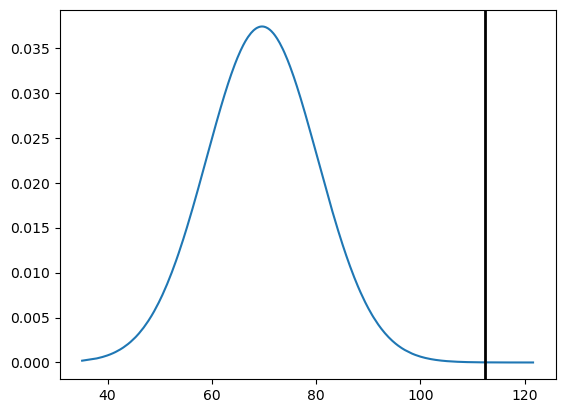

In [27]:
x = np.random.normal(50, 3, 1000)
source = {"Genotype": ["CV1"]*1000, "AGW": x}
df=SWR_Temp_Trans_C.copy()


df.sort_values(by=['temp'], inplace=True)
df_mean = np.mean(df["temp"])
df_std = np.std(df["temp"])
pdf = stats.norm.pdf(df["temp"], df_mean, df_std)

STD4 = df_mean + (4*df_std)

plt.plot(df["temp"], pdf)
plt.axvline(x=STD4, color='black', linestyle='-', linewidth=2)



In [28]:
SWR_Temp_Trans_C[SWR_Temp_Trans_C['temp'] >= STD4]

,temp
Date,
1830-12-17 12:00:00,120.0
1830-12-28 15:00:00,113.0
1834-02-09 12:00:00,116.4
1854-01-07 12:00:00,116.6
1854-01-21 12:00:00,113.5
1855-01-01 12:00:00,116.6
1857-02-11 13:00:00,113.0
1861-12-30 16:00:00,117.0
1863-01-01 12:00:00,121.6


In [29]:
X = 0
(X - 32) * 5/9

-17.77777777777778

# We did not continue to check these